Loading and accessing tweets

In [31]:
# Load JSON
import json

In [39]:
TweetsNBA = []
with open('TweetsNBA_1.json') as f:
    for line in f:
        TweetsNBA.append(json.loads(line))

In [ ]:
import pandas as pd

In [129]:
tweets_list = []
for tweet_obj in TweetsNBA:
    #tweet_obj = json.loads(tweet)
    tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    if 'extended_tweet' in tweet_obj:
        tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    if 'retweeted_status' in tweet_obj:
        tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
        tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
    if  'quoted_status' in tweet_obj and 'extended_tweet' not in tweet_obj:
        tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
    if ('extended_tweet' in tweet_obj) and ('retweeted_status' in tweet_obj) :
        tweet_obj['retweeted_status-extended_tweet-full_text'] = tweet_obj['retweeted_status']['full_text']
    else:
        tweet_obj['retweeted_status-extended_tweet-full_text']= None
    if ('extended_tweet' in tweet_obj) and ('quoted_status' in tweet_obj) :
        tweet_obj['quoted_status-extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    tweets_list.append(tweet_obj)

In [130]:
df_TweetsNBA = pd.DataFrame(tweets_list)

In [131]:
df_TweetsNBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 44 columns):
contributors                                 0 non-null object
coordinates                                  2 non-null object
created_at                                   10000 non-null object
display_text_range                           1549 non-null object
entities                                     10000 non-null object
extended_entities                            4599 non-null object
extended_tweet                               305 non-null object
extended_tweet-full_text                     305 non-null object
favorite_count                               10000 non-null int64
favorited                                    10000 non-null bool
filter_level                                 10000 non-null object
geo                                          2 non-null object
id                                           10000 non-null int64
id_str                                     

In [132]:
def check_word_in_tweet(word, data):
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, False)
    return contains_column

Comparing @cavs to @warriors

In [137]:
import numpy as np
cavs = check_word_in_tweet('@cavs', df_TweetsNBA)
warriors = check_word_in_tweet('@warriors ', df_TweetsNBA)
print("Proportion of @cavs tweets:", np.sum(cavs) / df_TweetsNBA.shape[0])
print("Proportion of @warriors tweets:", np.sum(warriors) / df_TweetsNBA.shape[0])

Proportion of @cavs tweets: 0.0411
Proportion of @warriors tweets: 0.0114


# Sentiment

In [139]:
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [140]:
# Generate sentiment scores
sentiment_scores = df_TweetsNBA['text'].apply(sid.polarity_scores)

In [144]:
sentiment_scores[0]

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

## Twitter Network

### Creating retweet network

In [145]:
import networkx as nx
G_rt = nx.from_pandas_edgelist(
    df_TweetsNBA,
    source = 'user-screen_name',
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
 
print('Nodes in RT network:', len(G_rt.nodes()))
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 8944
Edges in RT network: 9314


### Creating reply network

In [151]:
import networkx as nx
G_reply = nx.from_pandas_edgelist(
    df_TweetsNBA,
    source = 'user-screen_name',
    target = 'in_reply_to_screen_name',
    create_using = nx.DiGraph())
print('Nodes in reply network:', len(G_reply.nodes()))
print('Edges in reply network:', len(G_reply.edges()))

Nodes in reply network: 8831
Edges in reply network: 8804


### Visualizing retweet network

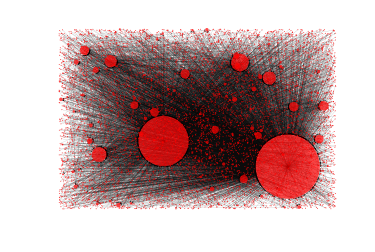

In [147]:
import matplotlib.pyplot as plt 
pos = nx.random_layout(G_rt)
sizes = [x[1] for x in G_rt.degree()]
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)
plt.axis('off'); plt.show()

In [152]:
rt_centrality = nx.in_degree_centrality(G_rt)
reply_centrality = nx.in_degree_centrality(G_reply)
rt = pd.DataFrame(list(rt_centrality.items()), columns = ['screen_name', 'degree_centrality'])
reply = pd.DataFrame(list(reply_centrality.items()), columns = ['screen_name', 'degree_centrality'])
print(rt.sort_values('degree_centrality', ascending = False).head())
print(reply.sort_values('degree_centrality', ascending = False).head())

     screen_name  degree_centrality
3            NaN           0.460919
7            NBA           0.281226
30   Arabic1_NBA           0.033993
168        NBATV           0.024153
1           cavs           0.018674
     screen_name  degree_centrality
1           None           0.978822
1172   KingJames           0.003964
171         cavs           0.001586
197          NBA           0.000906
1681  directvnow           0.000453
